## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

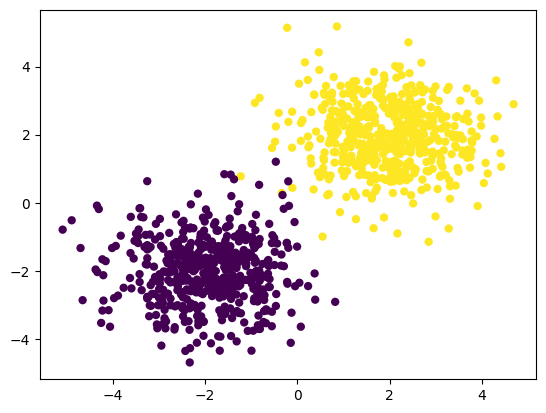

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

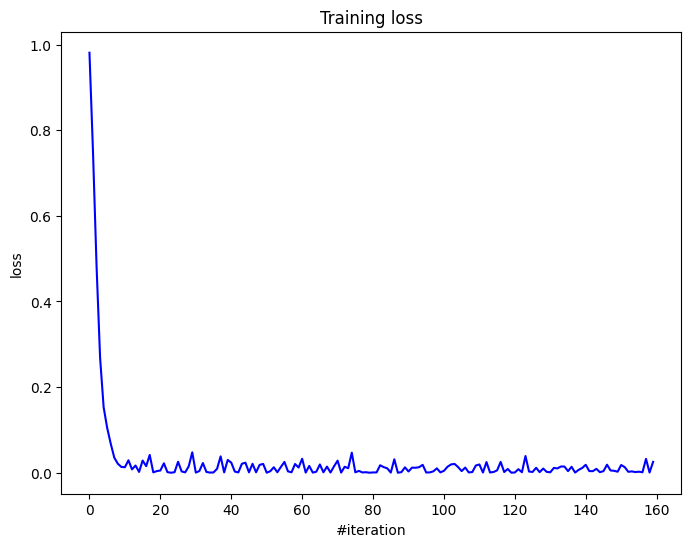

Current loss: 0.025348


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        # print(predictions)
        loss = criterion.forward(predictions, y_batch)
        # print(loss)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] ** 2)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] ** 2)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] ** 2)

np.shape(X_train)

(50000, 784)

One-hot encode the labels first.

In [11]:
# Your code goes here. ################################################
'''
Закодируем каждое число в виде вектора, 
где единичка будет стоять на той позиции, 
которая соответсвует числу. 
(для 0 -- единичка на нулевой позиции, для 5 -- на пятой и т п)
'''
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)] = 1.
    return y_one_hot

print("Basik labels vecor:")
print(y_train)
print()

n_classes = 10
y_train = one_hot_encode(n_classes, y_train)
y_val = one_hot_encode(n_classes, y_val)

print("Hot encoded labels vector:")
print(y_train)

Basik labels vecor:
[5 0 4 ... 8 4 8]

Hot encoded labels vector:
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [12]:
# Your code goes here. ################################################
'''
Напишем функцию, которая конструирует нейронную сеть с заданной функцией активации.
activator -- заданная функция активации
normalization -- нужно ли включать нормализацию данных
'''
def get_neural_networks(activator=ReLU, normalization=False):
    net = Sequential()
    net.add(Linear(X_train.shape[-1], 96))
    if normalization:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(96))
    net.add(activator())
    net.add(Linear(96, y_train.shape[-1]))
    net.add(LogSoftMax())
    return net

In [14]:
'''
Напишем функцию, которая обучает заданную ей нейронную сеть. В параметрах сети можно задать саму нейронку,
функцию потерь и вид оптимайзера (вид градиентного спуска).

network -- ссылка на нейронку
train_set_objects, train_labels -- объекты и метки из тренеровочной выборки 
batch_size -- размер батча
n_epoch -- количество эпох обучения
criterion -- функция потерь
optimizer -- вид градиентного спуска
config -- словарь с конфигурационными параметрами для оптимайзера
'''
def train_neural_networks(network, 
                          train_set_objects, train_labels, 
                          batch_size=128, 
                          n_epoch=10,
                          criterion=ClassNLLCriterion(),
                          optimizer=sgd_momentum, 
                          config={'learning_rate' : 1e-1, 'momentum': 0.9}):
    optimizer_state = {}
    # в этот список будем накапливать историю ошибок в процессе обучения нейросети,
    # чтобы потом посмотреть ее на графике
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((train_set_objects, train_labels), batch_size):  
            # для каждого нового батча зануляем градиенты
            network.zeroGradParameters()
            # делаем предсказание
            predictions = network.forward(x_batch)
            # считаем функцию потерь
            loss = criterion.forward(predictions, y_batch)
            # считаем производную функции потерь
            dp = criterion.backward(predictions, y_batch)
            # с помощью посчитанной производной функции потерь делаем backpropogation 
            # (считаем производную) сложной функции на всех слоях нейросети
            network.backward(x_batch, dp)

            # делаем шаг градиентного спуска
            optimizer(network.getParameters(), 
                      network.getGradParameters(), 
                      config,
                      optimizer_state)      
            
            loss_history.append(loss)
    return loss_history


Будем исследовать одинаковые модели с разными функкциями активации и посмторим, как различные функции активации влияют на поведение ошибки модели в процессе обучения. Для этого обучим все модели на одних и тех же данных, на одинаковом количестве эпох и на одном графике построим эволюцию ошибки всех моделей в процессе обучения.

Кроме того, добавим в каждую модель нормировку данных (BatchNorm + Shift and Scale) и посмотрим, как изменится поведение всех моделей в этом случае.

In [20]:
'''
Создаем все необходимые модели.
'''
neural_networks = {
    "ReLu" : get_neural_networks(activator=ReLU),
    "ELU" : get_neural_networks(activator=ELU),
    "LeakyReLU" : get_neural_networks(activator=LeakyReLU),
    "SoftPlus" : get_neural_networks(activator=SoftPlus),

    "BatchNormReLu" : get_neural_networks(activator=ReLU, normalization=True),
    "BatchNormELU" : get_neural_networks(activator=ELU, normalization=True),
    "BatchNormLeakyReLU" : get_neural_networks(activator=LeakyReLU, normalization=True),
    "BatchNormSoftPlus" : get_neural_networks(activator=SoftPlus, normalization=True)
}

In [21]:
from datetime import datetime
'''
Обучим все модели.
'''
neural_networks_train_history = {}
model_train_time = {}

for model_name, model in neural_networks.items():
    # будем так же замерять время тренировки модели
    start_time = datetime.now().timestamp()
    neural_networks_train_history[model_name] = train_neural_networks(model,
                                                                      X_train, y_train, 
                                                                      batch_size=2500)
    exec_time = datetime.now().timestamp() - start_time
    model_train_time[model_name] = exec_time

Text(0, 0.5, 'loss')

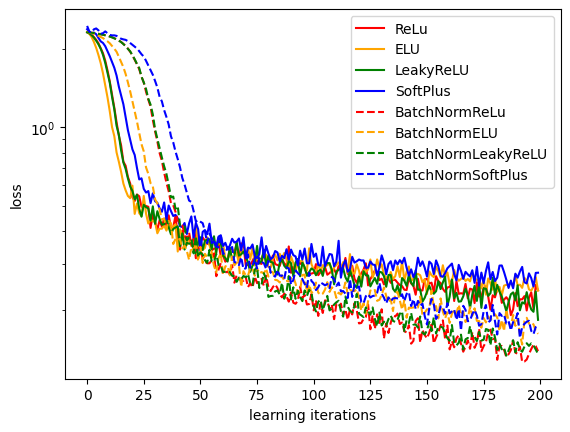

In [22]:
'''
Примечание: по оси абцисс отложены итерации обучения, а не эпохи. Количество итераций зависит от количества
эпох, а также, от соотношения размера обучающей выборки и размера батча.
'''

# a little trik to make final plot more beautiful
model_colors = {
    "ReLu" : "red",
    "ELU" : "orange",
    "LeakyReLU" : "green",
    "SoftPlus" : "blue",

    "BatchNormReLu" : "red",
    "BatchNormELU" : "orange",
    "BatchNormLeakyReLU" : "green",
    "BatchNormSoftPlus" : "blue"
}

for model_name in neural_networks.keys():
    # a little trik to make final plot more beautiful
    line_style = '-'
    if "BatchNorm" in model_name:
        line_style = '--'
        
    plt.plot(range(len(neural_networks_train_history[model_name])), 
             neural_networks_train_history[model_name], 
             label=model_name,
             linestyle=line_style,
             color=model_colors[model_name])

plt.legend()
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

Text(0.5, 1.0, 'Exec time comparation')

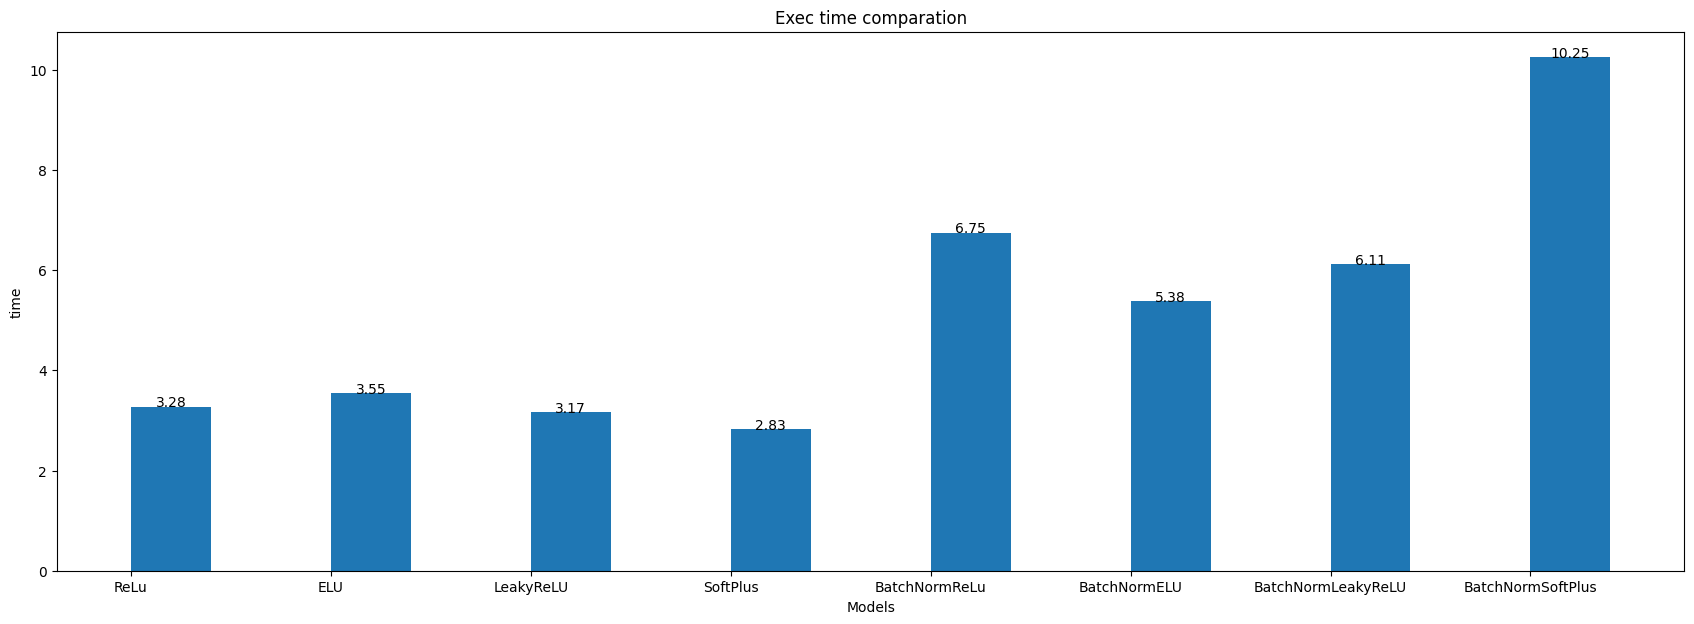

In [25]:
def add_bar_labels(obj_x, obj_y) -> None:
    for x, y in zip(obj_x, obj_y):
        plt.text(x, y, round(y, 2), ha='center')
model_names = list(model_train_time.keys())

# make x labels for bar plot + some magic for plot view
x_ticks = np.arange(0, len(model_names)*5, 5)
standart_width = 2

fig = plt.figure(figsize=(21, 7))

plt.bar(x_ticks + standart_width/2, list(model_train_time.values()), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, model_train_time.values())

plt.xticks(x_ticks, model_names)
plt.xlabel("Models")
plt.ylabel("time")
plt.title(f"Exec time comparation")

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

### Вывод
Наилучший результат показали модели, использующие в качестве функции активации ReLu и LeakyReLU (красный и зеленый графики показали наилучшие результаты). Данный результат может быть связан с особенностями задачи, простотой подсчета обратного распространения (это видно по времени работы). 
Видно, что добавление нормировки данных увеличило время обучения модели (теперь считать обратное распространение труднее и дольше, да и вообще, мы как бы 2 слоя добавили, а значит, сеть стала солжнее), но увеличили качество всех моделей (пунктирные графики, показывают лучшие результаты, чем непрерывные).

Теперь сравним сходимость моделей с использованием разных методов градиентного спуска.

In [26]:
neural_network_sgd = get_neural_networks()
neural_network_adam = get_neural_networks()

adam_config = {'learning_rate' : 1e-1, 'beta1' : 0.9, 'beta2' : 0.9, 'epsilon' : 1e-4}
model_train_time = {}

In [27]:
# будем так же замерять время тренировки модели
start_time = datetime.now().timestamp()
sgd_train_history = train_neural_networks(neural_network_sgd, X_train, y_train, batch_size=3000)
exec_time = datetime.now().timestamp() - start_time
model_train_time["sgd"] = exec_time

In [28]:
# будем так же замерять время тренировки модели
start_time = datetime.now().timestamp()
adam_train_history = train_neural_networks(neural_network_adam, X_train, y_train, batch_size=3000, optimizer=adam_optimizer,
                        config=adam_config)
exec_time = datetime.now().timestamp() - start_time
model_train_time["adam"] = exec_time

Text(0, 0.5, 'loss')

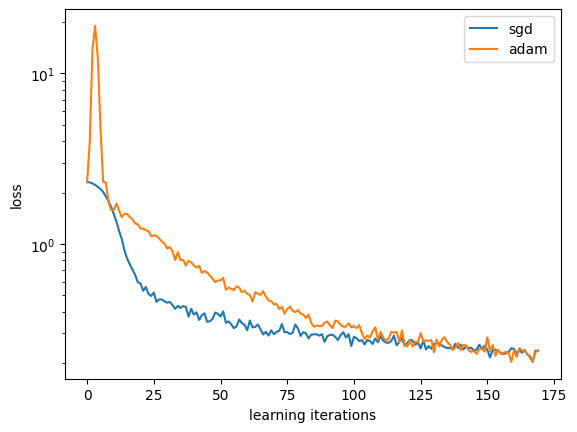

In [30]:
plt.plot(range(len(sgd_train_history)), sgd_train_history, label="sgd")
plt.plot(range(len(adam_train_history)), adam_train_history, label="adam")
plt.legend()
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

Text(0.5, 1.0, 'Exec time comparation')

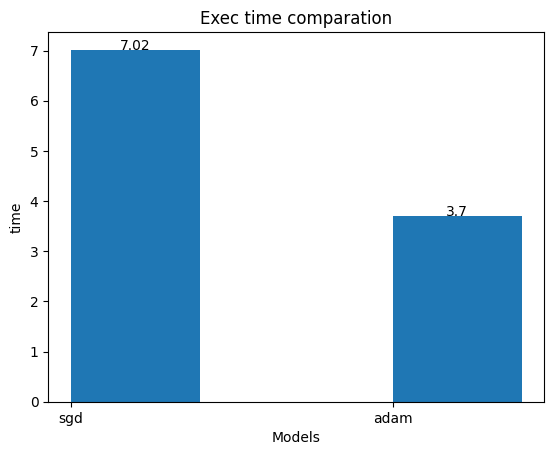

In [33]:
model_names = list(model_train_time.keys())

# make x labels for bar plot + some magic for plot view
x_ticks = np.arange(0, len(model_names)*5, 5)
standart_width = 2

plt.bar(x_ticks + standart_width/2, list(model_train_time.values()), width=standart_width)
add_bar_labels(x_ticks + standart_width/2, model_train_time.values())

plt.xticks(x_ticks, model_names)
plt.xlabel("Models")
plt.ylabel("time")
plt.title(f"Exec time comparation")

### Вывод
Как видно из графиков, хотя adam в самом начале и пошел совсем не туда (это нормально, такое поведение связано с особенностью метода и формой гиперповерхности в пространстве параметров), он показал лучший результат по сравнению с sgd, а так же лучшее время работы (сеть сошлась быстрее).

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [42]:
# Your code goes here. ################################################
'''
Построим свою супер-пупер сеть с блэкджеком и дропаутом, и с батчнормом.
'''
net = Sequential()
net.add(Linear(X_train.shape[-1], 96))
net.add(BatchNormalization(0.95))
net.add(ChannelwiseScaling(96))
net.add(ELU())
net.add(Dropout(0.4))
net.add(Linear(96, 32))
net.add(BatchNormalization(0.9))
net.add(ChannelwiseScaling(32))
net.add(LeakyReLU())
net.add(Dropout(0.15))
net.add(Linear(32, y_train.shape[-1]))
net.add(BatchNormalization(0.95))
net.add(ChannelwiseScaling(y_train.shape[-1]))
net.add(LogSoftMax())

Print here your accuracy on test set. It should be around 90%.

In [43]:
# Your answer goes here. ################################################
nn_train_history = train_neural_networks(net, 
                                         X_train, y_train, 
                                         batch_size=2500, 
                                         n_epoch=20, 
                                         optimizer=adam_optimizer, 
                                         config=adam_config)

Text(0, 0.5, 'loss')

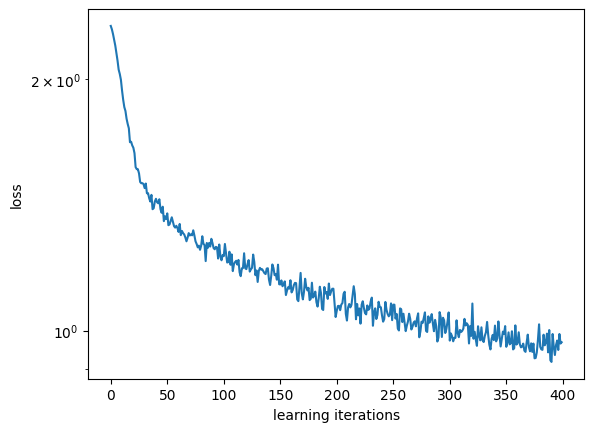

In [44]:
plt.plot(range(len(nn_train_history)), nn_train_history)
plt.gca().set_yscale('log')
plt.xlabel("learning iterations")
plt.ylabel("loss")

In [45]:
'''
Теперь посмотрим, как обученная модель ведет себя на тестовой выборке,
для этого переведем ее в режим evaluate.
'''
net.evaluate()
accuracies = []

# пройдемся батчами по тестовой выборке, посмотрим результат работы сети и выведем среднюю оценку
for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
    predicted = net.forward(x_batch)
    accuracies.append((np.argmax(predicted, axis=1) == y_batch).mean())
print(np.array(accuracies).mean())

0.9139636075949367


Кастомная сеть выдает около 90% точности на тесте.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [47]:
# Your beautiful code here.
import torch
import torch.nn.functional as F

'''
Сравним кастомную сеть с torch. Импортируем торч и сконструируем АБСОЛЮТНО такую же сеть.
'''
torch_net = torch.nn.Sequential(torch.nn.Linear(X_train.shape[-1], 96),
                                torch.nn.BatchNorm1d(96, momentum = 0.95),
                                torch.nn.ELU(),
                                torch.nn.Dropout(0.4),
                                torch.nn.Linear(96, 32),
                                torch.nn.BatchNorm1d(32, momentum = 0.9),
                                torch.nn.LeakyReLU(),
                                torch.nn.Dropout(0.15),
                                torch.nn.Linear(32, y_train.shape[-1]),
                                torch.nn.BatchNorm1d(y_train.shape[-1], momentum = 0.9),
                                torch.nn.LogSoftmax())

opt = torch.optim.Adam(torch_net.parameters(), lr=1e-1)
loss_fn = torch.nn.CrossEntropyLoss()

/home/pavel/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


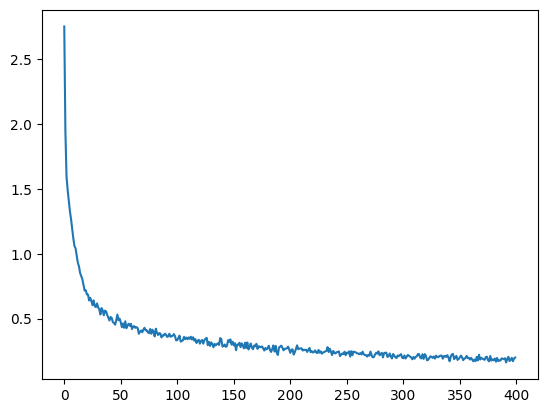

In [48]:
loss_history = []
torch_net.train()
for i in range(20):
    for x_batch, y_batch in get_batches((X_train, y_train), 2500):
        predicted = torch_net(torch.tensor(x_batch, dtype=torch.float32))
        loss = loss_fn(predicted, torch.tensor(y_batch, dtype=torch.float32))
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_history.append(loss.item())
plt.plot(loss_history)

In [49]:
torch_net.eval()
accuracies = []

# пройдемся батчами по тестовой выборке, посмотрим результат работы сети и выведем среднюю оценку
for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
    predicted = torch_net.forward(torch.from_numpy(x_batch))
    accuracies.append((np.argmax(predicted.detach().numpy(), axis=1) == y_batch).mean())
print(np.array(accuracies).mean())

0.9646954113924051


### Вывод
Нейронная сеть на PyTorch выдает результат в среднем на 5% лучше, чем кастомная сеть, использующая под капотом написанные нами функции. Кроме того, обучается торчовая сеть тоже быстре. Ну, это и понятно, PyTorch писали умные люди, делали там ускорение на GPU, а я просто бедный алкоголик с РТ. 

Тем не менее, считаю результирующие показатели успешными. Нам удалось приблизиться к результату функционала PyTorch.